# Data loading

In [1]:
import numpy as np
import os
import pickle
from matplotlib import pyplot as plt
import scipy.stats
from scipy.stats import kurtosis, skew, t

In [2]:
GDN_outputs = np.array(os.listdir('/GDN_outputs'))
GDN_outputs = [(file, file[-44:-36]) for file in GDN_outputs if file!='.DS_Store']
GDN_outputs = sorted(GDN_outputs, key=lambda x: x[1])

GCN_outputs = np.array(os.listdir('/GCN_outputs'))
GCN_outputs = [(file, file[-44:-36]) for file in GCN_outputs if file!='.DS_Store']
GCN_outputs = sorted(GCN_outputs, key=lambda x: x[1])

In [3]:
dates = [day for (name, day) in GDN_outputs]
dates

['20071116', '20080415', '20080905', '20090129', '20090623']

In [4]:
def data_grabber(model, date):
    if model=='GDN':
        string = 'GDN_outputs/' + next(name for (name, day) in GDN_outputs if day==date)
        
    else:
        string = 'GCN_outputs/' + next(name for (name, day) in GCN_outputs if day==date)

    with open(f'/finance_data/{string}', 'rb') as f:   # Unpickling
        outputs = pickle.load(f)
        
    return outputs

In [5]:
def quantile_pnl(test_ys, percent_to_trade, weighted):
    n = len(test_ys)
    
    pnl = []
    
    for i in range(n):
        q = np.quantile(np.abs(test_ys[i][0]), 1-percent_to_trade)
        boolean = np.logical_or(np.logical_or(test_ys[i][0]>q, test_ys[i][0]<-q), test_ys[i][0]==q)
        quantile_y_hats = test_ys[i][0][boolean]
        quatile_ys = test_ys[i][1][boolean]
    
        if weighted==False:
            d = len(quantile_y_hats)
            pnl.append(np.dot(np.sign(quantile_y_hats), quatile_ys)/d)
        else:
            d = np.abs(quantile_y_hats).sum()
            pnl.append(np.dot(quantile_y_hats, quatile_ys)/d)
        
    pnl = np.array(pnl)
    
    ppt = pnl.mean()*100*100  # This is PnL per trade in bpts
    
    annualised_av_rtn = ppt*252/100
    
    annualised_sharpe = np.sqrt(252)*pnl.mean()/pnl.std()    
    
    return pnl, round(annualised_sharpe, 3), round(ppt, 3), round(annualised_av_rtn, 3)

# Cumsum plots

In [6]:
def cumsum_plotter(model, dates):       
    fig, ax = plt.subplots(figsize=(6, 2.5))
    
    cols = plt.rcParams['axes.prop_cycle'].by_key()['color'][:4]

    for weighted in ('W', 'NW'):
        for i, percent in enumerate([0.25, 0.5, 0.75, 1]):
            y = []
            for date in dates:
                test_ys = data_grabber(model, date)[4]
                if weighted=='W':
                    y.extend(quantile_pnl(test_ys, percent, True)[0])
                else:
                    y.extend(quantile_pnl(test_ys, percent, False)[0])

            y = np.array(y)
            
            if weighted=='W':
                ax.plot(y.cumsum(), label=f'W{int(percent*100)}', linestyle='-', color=cols[i])
            else:
                ax.plot(y.cumsum(), label=f'NW{int(percent*100)}', linestyle='--', color=cols[i])

            print(f'{weighted}{int(percent*100)} Annualised Sharpe = {np.sqrt(252)*y.mean()/y.std():.2f}')
            
    plt.axhline(y=0, color='black')
    plt.xlabel('Train/Test Day')
    plt.title(f'{model} Cumsum PnL')
    plt.legend(loc="upper left", title="Portfolio", fontsize=7.2, title_fontsize=8, ncol=2)
    
    plt.show()

W25 Annualised Sharpe = 4.41
W50 Annualised Sharpe = 4.05
W75 Annualised Sharpe = 4.00
W100 Annualised Sharpe = 3.91
NW25 Annualised Sharpe = 4.04
NW50 Annualised Sharpe = 3.00
NW75 Annualised Sharpe = 2.73
NW100 Annualised Sharpe = 2.23


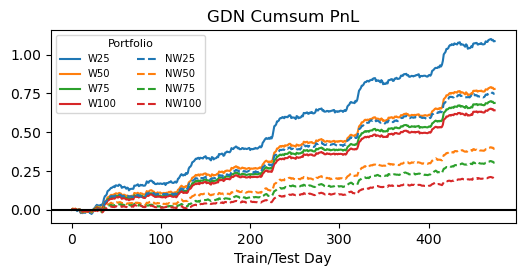

In [7]:
cumsum_plotter('GDN', dates)

W25 Annualised Sharpe = 1.00
W50 Annualised Sharpe = 0.86
W75 Annualised Sharpe = 0.70
W100 Annualised Sharpe = 0.65
NW25 Annualised Sharpe = 0.27
NW50 Annualised Sharpe = 0.09
NW75 Annualised Sharpe = -0.51
NW100 Annualised Sharpe = -0.79


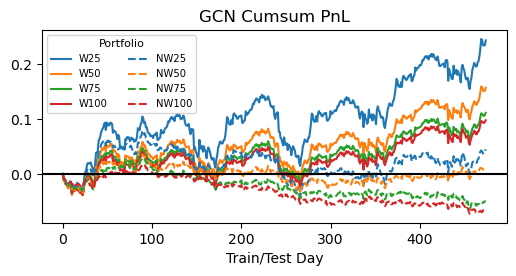

In [8]:
cumsum_plotter('GCN', dates)

# Comparative plots

In [9]:
def bar_chart_plotter(metric, dates):           
    if metric=='Sharpe':
        t = 1
    elif metric=='PPT':
        t = 2
    elif metric=='Return':
        t = 3
    
    mod = []
    data = {}

    for i, model_weight in enumerate(['GDN_w', 'GDN_n', 'GCN_w', 'GCN_n']):
        if model_weight[-1]=='n':
            weight_name = 'Non-Weighted'
            weighted = False
        else:
            weight_name = 'Weighted'
            weighted = True
        
        mod.append(model_weight[:-2]+' '+weight_name)

        for percent in [0.25, 0.5, 0.75, 1]:
            y = []
            for date in dates:
                test_ys = data_grabber(model_weight[:-2], date)[4]
                y.extend(test_ys)

            y = np.array(y)
            
            
            if i==0:
                data.update({f'{int(percent*100)}': [quantile_pnl(y, percent, weighted)[t]]})
            else:
                data[f'{int(percent*100)}'].append(quantile_pnl(y, percent, weighted)[t])
        

    x = np.arange(len(mod))  # the label locations
    
    width = 0.22  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=(7, 3))

    
    for attribute, measurement in data.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3, fontsize=9)
        multiplier += 1

    if t==1:
        ax.set_title(f'Annualised Sharpe Ratio')
    if t==2:
        ax.set_title(f'PnL per Trade (bpts)')
    if t==3:
        ax.set_title(f'Annualised Average Return (%)')
    
    plt.axhline(y=0, color='black')
    
    ax.set_xticks(x + 1.5*width, mod)
    ax.legend(loc='best', ncols=1, fontsize=9.5, title="% Traded")

    plt.show()

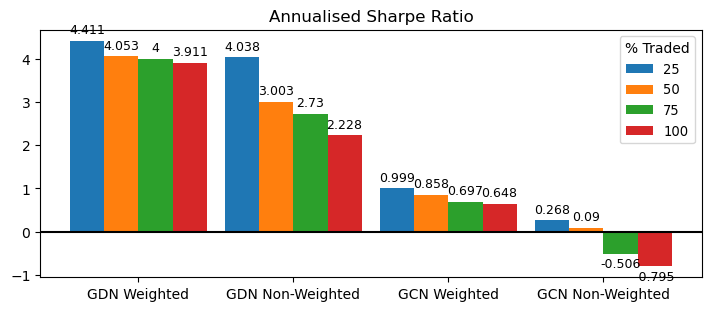

In [10]:
bar_chart_plotter('Sharpe', dates)

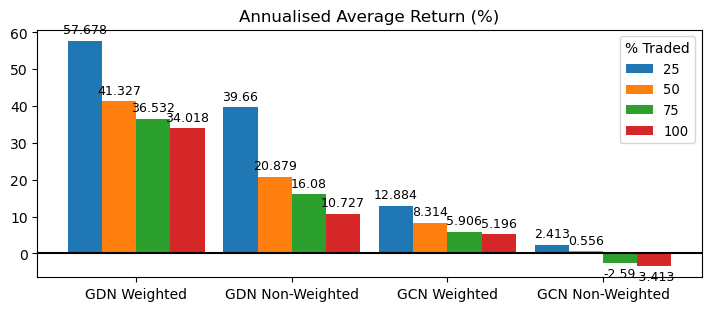

In [11]:
bar_chart_plotter('Return', dates)

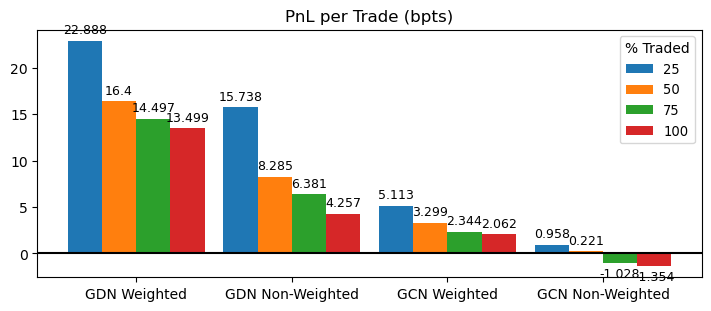

In [12]:
bar_chart_plotter('PPT', dates)

# Sharpe Ratio Tests

In [33]:
def sharpe_test(model, percent, weighted): 
    y = []
    for date in dates:
        test_ys = data_grabber(model, date)[4]
        y.extend(quantile_pnl(test_ys, percent, weighted)[0])
        
    pnl = np.array(y)
    sharpe = pnl.mean()/pnl.std()
    print(f'Annualised Sharpe = {sharpe*np.sqrt(252):.3f}')
    t_obs = sharpe/np.sqrt(((1-skew(pnl))*sharpe + (kurtosis(pnl)-1)*(sharpe**2)/4)/(len(pnl)-1))
    p = 1 - scipy.stats.norm(0, 1).cdf(t_obs)
    print(f'p-value = {p:.6f}')

In [34]:
sharpe_test('GDN', 1, False)

Annualised Sharpe = 2.228
p-value = 0.000000


# T-tests

In [15]:
def ttest_data(model, dates, percent, weighted):
    y = []
    for date in dates:
        test_ys = data_grabber(model, date)[4]        
        y.extend(test_ys)
    y = np.array(y)
    pnl = quantile_pnl(y, percent, weighted)[0]
    Y_bar = pnl.mean()
    s = pnl.std()
    N = len(pnl)
    
    return Y_bar, s, N

In [16]:
# This verifies all GDN/GCN pairs are within 16% - giving justification for the equal variance t-test

max_var_diff = 0

for p in [1, 0.75, 0.5, 0.25]:
    for weighted in [True, False]:
        GDN_s = ttest_data('GDN', dates, p, weighted)[1]
        GCN_s = ttest_data('GCN', dates, p, weighted)[1]
        
        if GDN_s > GCN_s:
            if GDN_s/GCN_s > max_var_diff:
                max_var_diff = GDN_s/GCN_s
        else:
            if GCN_s/GDN_s > max_var_diff:
                max_var_diff = GCN_s/GDN_s

print(f'Max GDN/GCN pair variance difference = {100*(max_var_diff - 1):.2f}%')

Max GDN/GCN pair variance difference = 15.11%


In [29]:
def ttest(dates, percent, weighted):
    Y_1, s_1, N_1 = ttest_data('GDN', dates, percent, weighted)
    Y_2, s_2, N_2 = ttest_data('GCN', dates, percent, weighted)
    
    s = np.sqrt(((N_1 - 1)*s_1**2 + (N_2 - 1)*s_2**2)/(N_1 + N_2 -2))
    
    t_obs = (Y_1 - Y_2)/(s*np.sqrt((1/N_1)+(1/N_2)))
    
    df = N_1 + N_2 - 2
    
    print(f'p-value = {1 - t.cdf(t_obs, df):.6f}')

In [30]:
ttest(dates, 1, False)

p-value = 0.001345
